In [1]:
import os
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy 
import pandas as pd
import time
import datetime

# from keras.models import Sequential, load_model
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)


from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
# from tslearn.metrics import dtw, soft_dtw
#euclidean

Using TensorFlow backend.


# Demo 

In [2]:
X_hat = random_walks(n_ts=50, sz=32, d=1)
km = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=10,random_state=0).fit(X_hat)
print(km.cluster_centers_.shape)

(2, 32, 1)


In [3]:
print(X_hat.shape)
#row - num of timeseries, col - num of enteries, d - dim

(50, 32, 1)


In [4]:
# https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html?highlight=TimeSeriesKMeans
X= km.fit_predict(X_hat)

In [5]:
print(X.shape)

(50,)


# Preprocessing


In [6]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()
housing_data = []
housing_data_numpy = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)
    # housing_data_numpy.append(housing_data[i]['grid'].to_numpy())

df = housing_data[0]['grid']

In [7]:
def get_avg_day(look_back =96,  house = 0, absolute = False):

    dataframe = housing_data[house]['grid']
    fulldays=len(dataframe)//look_back
    grid_data=dataframe.to_numpy()

    grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, look_back)
    if absolute == True:
        grid_day_matrix = abs(grid_day_matrix)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return avg_house_grid

In [8]:
avg_house_list = []
for i in range(len(housing_data)):
    avg_house_list.append(get_avg_day(house= i))
np_avg_house = np.asarray(avg_house_list) 
r,c =np_avg_house.shape
np_avg_house = np.reshape(np_avg_house,(r,c,1))

In [9]:
np_avg_house.shape

(25, 96, 1)

# Clustering

In [10]:
nathan_truth = [0,0,0,1,0,
                0,0,1,1,1,
                1,1,0,0,0,
                1,1,1,1,0,
                0,0,1,0,1]
#what I think the right classes are

In [11]:
avg_house_list = []
for i in range(len(housing_data)):
    avg_house_list.append(get_avg_day(house= i))
np_avg_house = np.asarray(avg_house_list) 
r,c =np_avg_house.shape
np_avg_house = np.reshape(np_avg_house,(r,c,1))

In [12]:
clusting_model = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=50,random_state=0).fit(np_avg_house)
print(clusting_model.cluster_centers_.shape)

(2, 96, 1)


In [13]:
print(clusting_model.cluster_centers_.shape)

(2, 96, 1)


In [14]:
houseclasses= clusting_model.fit_predict(np_avg_house)

In [15]:
houseclasses

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1], dtype=int64)

In [16]:
print(X.shape)

(50,)


In [17]:
os.remove("../models/KM/KM1.h5")
path = '../models/KM/KM1.h5'
clusting_model.to_hdf5(path)

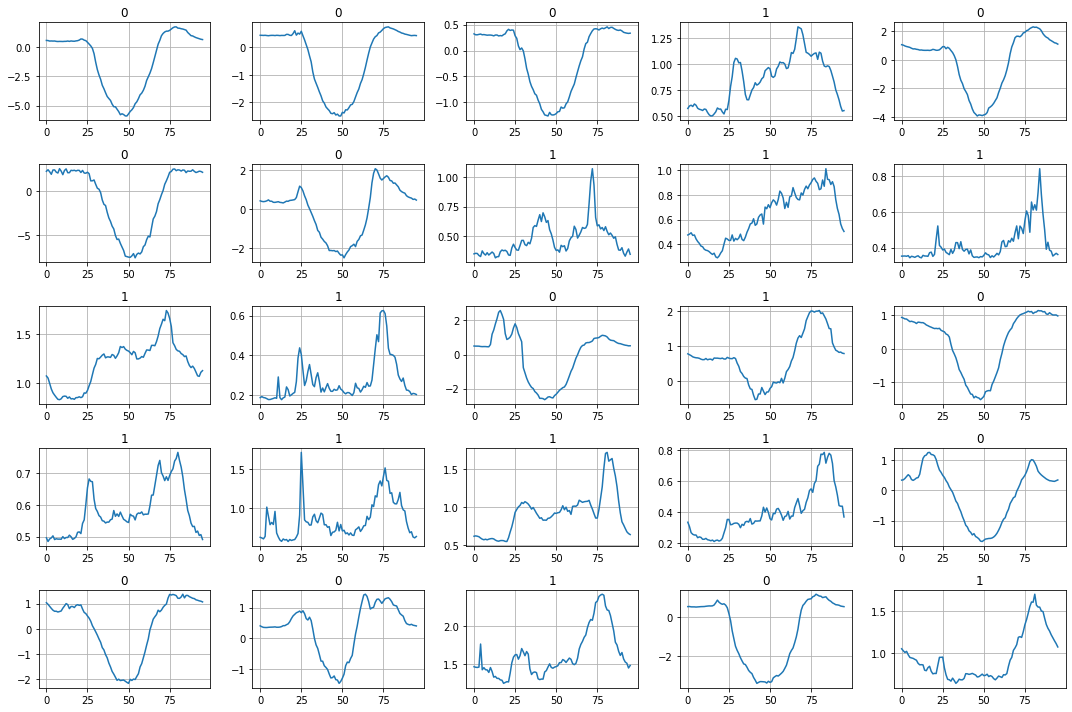

In [18]:
plt.figure(figsize=(15, 10))
for i in range(len(avg_house_list)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    plt.plot(avg_house_list[i])
    plt.title(f'{houseclasses[i]}')
    plt.grid(True)
plt.tight_layout()

In [19]:
math.sqrt(mean_squared_error(nathan_truth, houseclasses))

0.2

In [20]:
avg_house_list_abs = []
for i in range(len(housing_data)):
    avg_house_list_abs.append(get_avg_day(house= i, absolute =True))
np_avg_house_abs = np.asarray(avg_house_list_abs) 
r,c =np_avg_house_abs.shape
np_avg_house_abs = np.reshape(np_avg_house_abs,(r,c,1))

In [21]:
clusting_model_abs = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=50,random_state=0).fit(np_avg_house_abs)

In [22]:
houseclasses_abs= clusting_model_abs.fit_predict(np_avg_house_abs)

In [23]:
os.remove("../models/KM/KM1_abs.h5")
path = '../models/KM/KM1_abs.h5'
clusting_model_abs.to_hdf5(path)

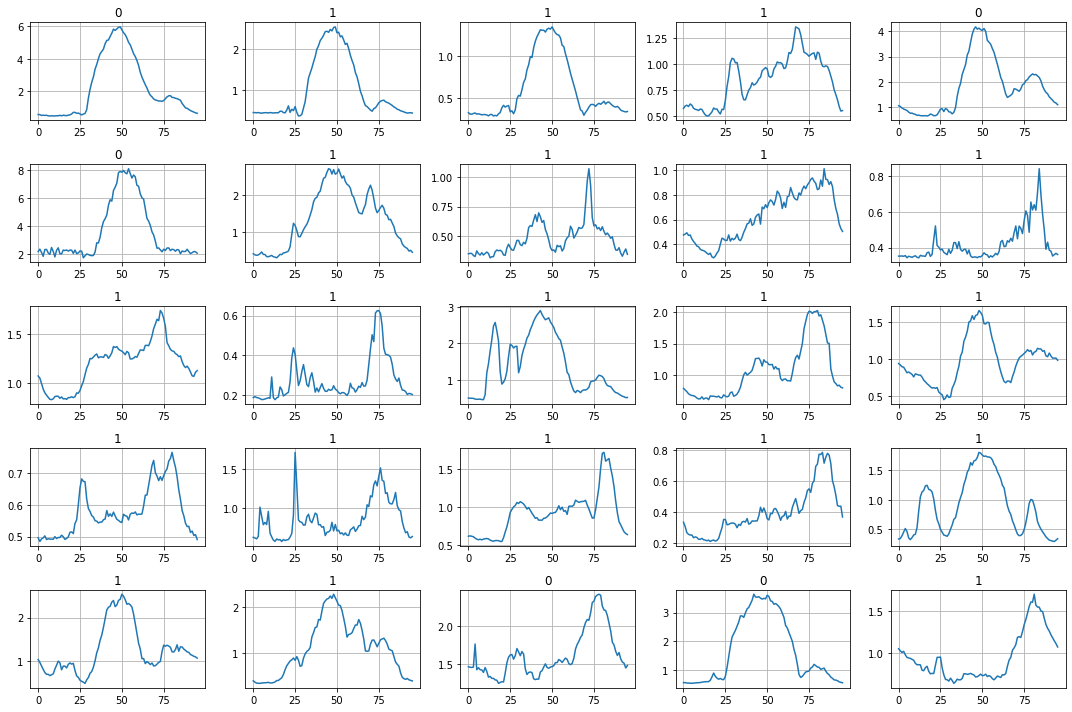

In [24]:
plt.figure(figsize=(15, 10))
for i in range(len(avg_house_list_abs)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    plt.plot(avg_house_list_abs[i])
    plt.title(f'{houseclasses_abs[i]}')
    plt.grid(True)
plt.tight_layout()

In [25]:
math.sqrt(mean_squared_error(nathan_truth, houseclasses_abs))

0.6324555320336759